# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Aprendizaje por refuerzos

### Trabajo práctico entregable 1/2 (materia completa)

**Estudiante:**
- [Chevallier-Boutell, Ignacio José.](https://www.linkedin.com/in/nachocheva/)

**Docentes:**
- Palombarini, Jorge (Mercado Libre).
- Barsce, Juan Cruz (Mercado Libre).

---

## Librerías

In [1]:
import itertools
from typing import Callable, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym

import time

Para ver los videos de las ejecuciones hay que tener instalado ffmpeg (`apt-get install ffmpeg`).

---
# Cliff walking: descripción del problema

Cliff walking es un juego que involucra moverse sobre un mapa (grilla 4x12) desde un punto inicial (Start, S) hasta un punto final (Goal, G), evitando caer por el precipicio (The Cliff).

![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

Imagen: Sutton y Barto, 2018.

Al comenzar un episodio, el jugador se ubica en el elemento [3, 0] de la grilla y debe llegar hasta el elemento [3, 11] para terminar dicho episodio. El precipio se ubica en [3, 1:11]. Cuando el jugador llega a uno de estos elementos, *se cae por el precipicio* y vuelve al punto inicial [3, 0]. El jugador debe realizar tantos movimientos como sean necesarios para llegar a la meta y finalizar el episodio.

El espacio de acciones $\mathcal{A}$ tiene 4 elementos:
- 0 $\Rightarrow$ Se mueve hacia arriba
- 1 $\Rightarrow$ Se mueve hacia la derecha
- 2 $\Rightarrow$ Se mueve hacia abajo
- 3 $\Rightarrow$ Se mueve hacia la izquierda

A pesar de que la grilla tiene 48 elementos, el jugador no puede estar en el precipicio, ya que vuelve al punto S, y tampoco puede estar en la meta, sino sólo llegar a ésta, ya que es el estado terminal del episodio. Esto resulta en que el espacio de estados $\mathcal{S}$ tiene 37 elementos. Para calcular el valor del estado asociado a cada elemento del mapa debemos calcular
    $$\text{Fila Actual} \times \text{Número de Columnas} + \text{Columna Actual}$$

donde debemos contar desde 0. De esta manera, el estado inicial es el estado 36.

Se cumple que $\mathcal{A}, \mathcal{S} \in \mathbb{N}$, teniendo al cero como primer elemento.

La función de recompensa es tal que el jugador recibe:
- $-100$ cuando cae el precipicio.
- $-1$ en todos los demás casos.

Recorrer el camino óptimo (Optimal path) requiere de 13 pasos temporales, obteniendo un retorno de -13. Por otro lado, recorrer el camino seguro (Safer path) requiere de 17 pasos temporales, obteniendo un retorno de -17.

---
# Ejercicio: SARSA + $\epsilon$-greedy

En esta actividad se implementa y ejecuta el algoritmo SARSA con una política $\epsilon$-greedy. Se estudia además el efecto de los hiperparámetros sobre la convergencia.

## Heurística de selección de acciones: política $\epsilon$-greedy

Se define a $\epsilon$-greedy como el método para decidir qué acciones tomar.

In [2]:
def epGreedy(
    state: int,
    actions: range,
    q: dict,
    hyperparameters: dict,
    random_state: np.random.RandomState
) -> int:

    """
    Elije una acción de acuerdo a una política de exploración-explotación 
    épsilon-greedy.
    Args:
        state: estado actual del agente
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        random_state: generador de números aleatorios
    """

    # Lista de valores q asociados a un estado-acción
    q_values = [q.get((state, a)) for a in actions]

    # Toma el valor máximo
    max_q = max(q_values)

    # Puede haber más de un valor máximo
    count = q_values.count(max_q)

    # Sortemaos un número aleatorio y comparamos con épsilon
    if random_state.uniform() < hyperparameters['epsilon']:
        # Exploramos, seleccionando una acción aleatoriamente
        return random_state.choice(actions)

    # Al no cumplirse la condición, explotamos
    elif count > 1:
        # Hay más de un valor máximo. Sorteamos alguno de ellos
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    
    else:
        # Hay un único valor máximo, eligiendo el correspondiente estado-acción
        i = q_values.index(max_q)

    return actions[i]

## Aprendizaje por diferencias temporales on-policy: SARSA

Se define a SARSA como el método de aprendizaje, tomando una transición y cambiando el diccionario de los valores de Q.

In [3]:
def SARSA_learning(
    state: int,
    action: int,
    reward: int,
    next_state: int,
    next_action: int,
    hyperparameters: dict,
    q: dict
) -> Tuple[int, int]:

    """
    Realiza una actualización según el algoritmo SARSA, para una transición de 
    estado dada.
    Args:
        state: estado actual del agente
        action: acción actual ejecutada por el agente
        reward: recompensa recibida al ejecutar la acción
        next_state: próximo estado del agente
        next_action: próxima acción del agente
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        q: diccionario de valores de estado-acción
    """

    # Actualizo el valor del estado-acción
    Target = reward + hyperparameters['gamma'] * q[(next_state, next_action)]
    TD_error = Target - q[(state, action)]
    q[(state, action)] += hyperparameters['alpha'] * TD_error

    # Actualizo el estado
    state = next_state

    # Actualizo la acción
    action = next_action

    return state, action

## Iteraciones

Se define la manera en la que itera el algoritmo SARSA.

In [4]:
def run_SARSA(
    policy: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    random_state: np.random.RandomState,
    max_iter: int
) -> Tuple[np.ndarray, np.ndarray, int, int, int, dict]:

    """
    Corre el algoritmo de RL, basado en SARSA.
    Args:
        policy: huerística de selección de acciones
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: entorno de Gymnasium
        actions: lista de acciones posibles
        random_state: generador de números aleatorios
        max_iter: cantidad máxima de pasos temporales
    """

    # Inicialización del diccionario de valores de estado-acción
    q = {}
    for s in range(49):
        for a in range(4):
            q[(s, a)] = 0.0

    # Registra la cantidad de pasos de cada episodio
    timesteps_of_episode = []

    # Registra el retorno de cada episodio
    return_of_episode = []

    # Casuísticas de finalización
    goal, drop, early = 0, 0, 0

    # Loop sobre los episodios
    for _ in range(episodes_to_run):
        # Instancea un nuevo agente en cada episodio
        # Fin del episodio: llegar a la salida o superar max_iter

        # Reinicia el entorno, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        # Retorno del episodio
        episode_return = 0

        # Contador de pasos temporales
        t = 0

        # Flag de finalización de iteración actual
        done = False

        # Elige la primera acción a ejecutar
        action = policy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # El agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Acumulamos recompensa
            episode_return += reward

            # Elige la nueva acción a ejecutar partiendo desde el nuevo estado
            next_action = policy(
                next_state, actions, q, hyperparameters, random_state)

            # Mecanismo de aprendizaje por TD con SARSA
            state, action = SARSA_learning(
                state, action, reward, next_state, next_action, hyperparameters, q)

            # Análisis de convergencia
            if terminated:
                # El agente alcanzó el objetivo
                goal += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif truncated:
                # El agente ejecutó una acción inválida
                drop += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif t >= max_iter:
                # Early stopping
                early += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            t += 1

    return timesteps_of_episode, return_of_episode, goal, drop, early, q

## Implementación

Se definen el entorno, los parámetros e hiperparámetros deseados para la corrida. Luego corre y, finalmente, guarda los resultados. Se pueden ejecutar barridas de parámetros gracias a los for anidados. A continuación se tienen celdas que grafican comparativamente.

### Run

In [5]:
env = gym.make("CliffWalking-v0")#, render_mode="human")
actions = range(env.action_space.n)
policy = epGreedy

max_iter = 2000
Sw_eps = [100000] # [10000, 20000, 30000, 40000, 50000, 100000, 150000, 200000] # [500, 5000, 10000, 20000]
Sw_a = [0.05] # [0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
Sw_g = [0.65] # [0.1, 0.25, 0.5, 0.6, 0.65, 0.7, 0.75, 0.9, 1]
Sw_e = [0.005] # [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                hyperparameters = {
                    "alpha": p_a,
                    "gamma": p_g,
                    "epsilon": p_e,
                }

                random_state = np.random.RandomState(1994)
                # random_state = np.random.RandomState(p_eps)

                start = time.time()
                ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_SARSA(
                    policy,
                    hyperparameters,
                    episodes_to_run,
                    env,
                    actions,
                    random_state,
                    max_iter
                )
                WallTime = time.time() - start

                env.close()

                # Guardamos los resultados
                runType = f'SARSA-{policy.__name__}'
                runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_e-{hyperparameters["epsilon"]}'

                with open(f'Outputs/Lab1/{runType}_{runPar}_{runHPar}.csv', 'w') as f:
                    f.write('Goal\tDrop\tEarly\tTotal\n')
                    f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                    f.write(f'Wall Time[s]\t{WallTime}\n')
                    
                    f.write('State\tAction\tQ-value\n')
                    for s in range(49):
                        for a in range(4):
                            f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                    f.write('Return\tTimeSteps\n')
                    for i in range(episodes_to_run):
                        f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

### Plot

Promediación de episodios y pasos temporales.

In [6]:
def mean_evol(Arr: np.ndarray) -> np.ndarray:
    """
    Suaviza la curva de aprendizaje o de recompensa.
    Args:
        Arr: array a suavizar
    """

    eps_val = np.linspace(1, len(Arr) + 1, len(Arr) + 1)
    cum_vals = np.cumsum(Arr)

    val_per_eps = [cum_vals[i] / eps_val[i] for i in range(len(cum_vals))]

    return np.array(val_per_eps)

Figura para comparar lo que ocurre al cambiar la cantidad de episodios y, además, ver que es determinista.

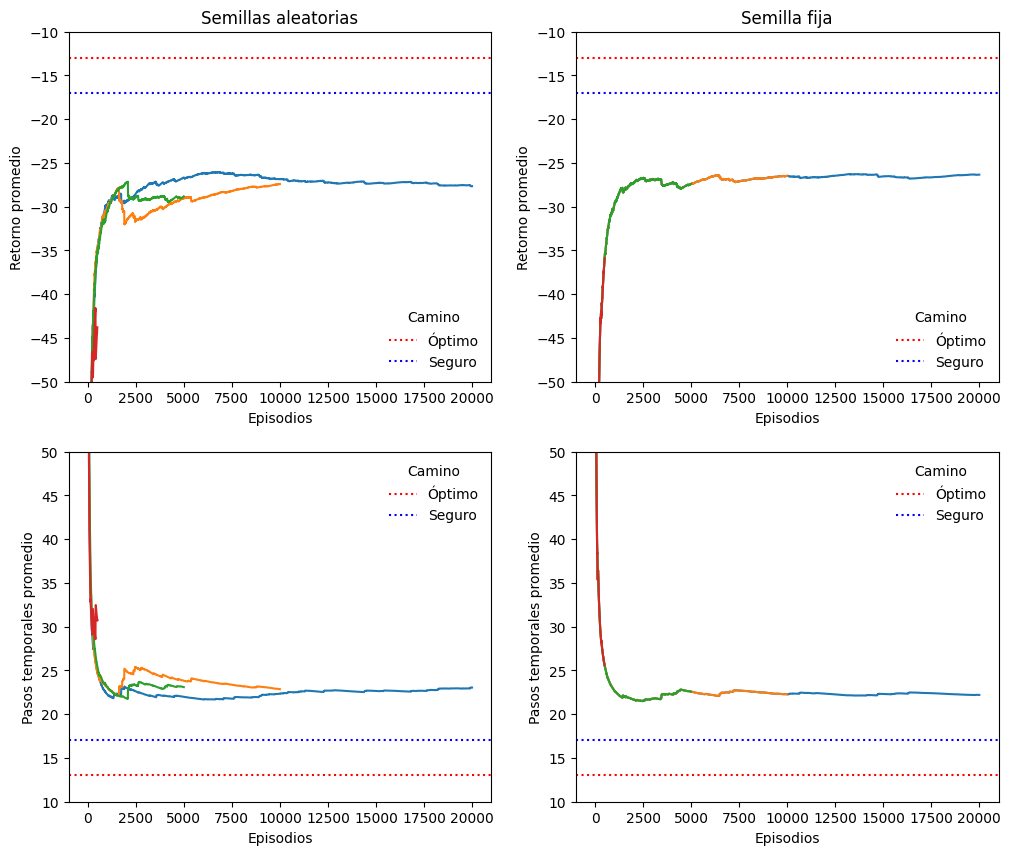

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for p_eps in [20000, 10000, 5000, 500]:

    # Semillas aleatorias (se usa el número de episodios p_eps correspondiente para reproducibilidad en la "aleatoriedad")
    File = pd.read_csv(f'Outputs/Lab1/Determinista/SARSA-epGreedy_its-2000_eps-{p_eps}_a-0.5_g-1_e-0.1_randomSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 0].plot(mean_evol(File[:,0]))
    axs[1, 0].plot(mean_evol(File[:,1]))

    # Semillas fija (1994)
    File = pd.read_csv(f'Outputs/Lab1/Determinista/SARSA-epGreedy_its-2000_eps-{p_eps}_a-0.5_g-1_e-0.1_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 1].plot(mean_evol(File[:,0]))
    axs[1, 1].plot(mean_evol(File[:,1]))

axs[0, 0].set_title('Semillas aleatorias')
axs[0, 1].set_title('Semilla fija')

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')
    axs[0, k].set_ylim(-50, -10)

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')
    axs[1, k].set_ylim(10, 50)

plt.savefig('Outputs/Lab1/Determinista/SARSA-epGreedy_its-2000_a-0.5_g-1_e-0.1.png')

Figura para comparar barrido de $\alpha$.

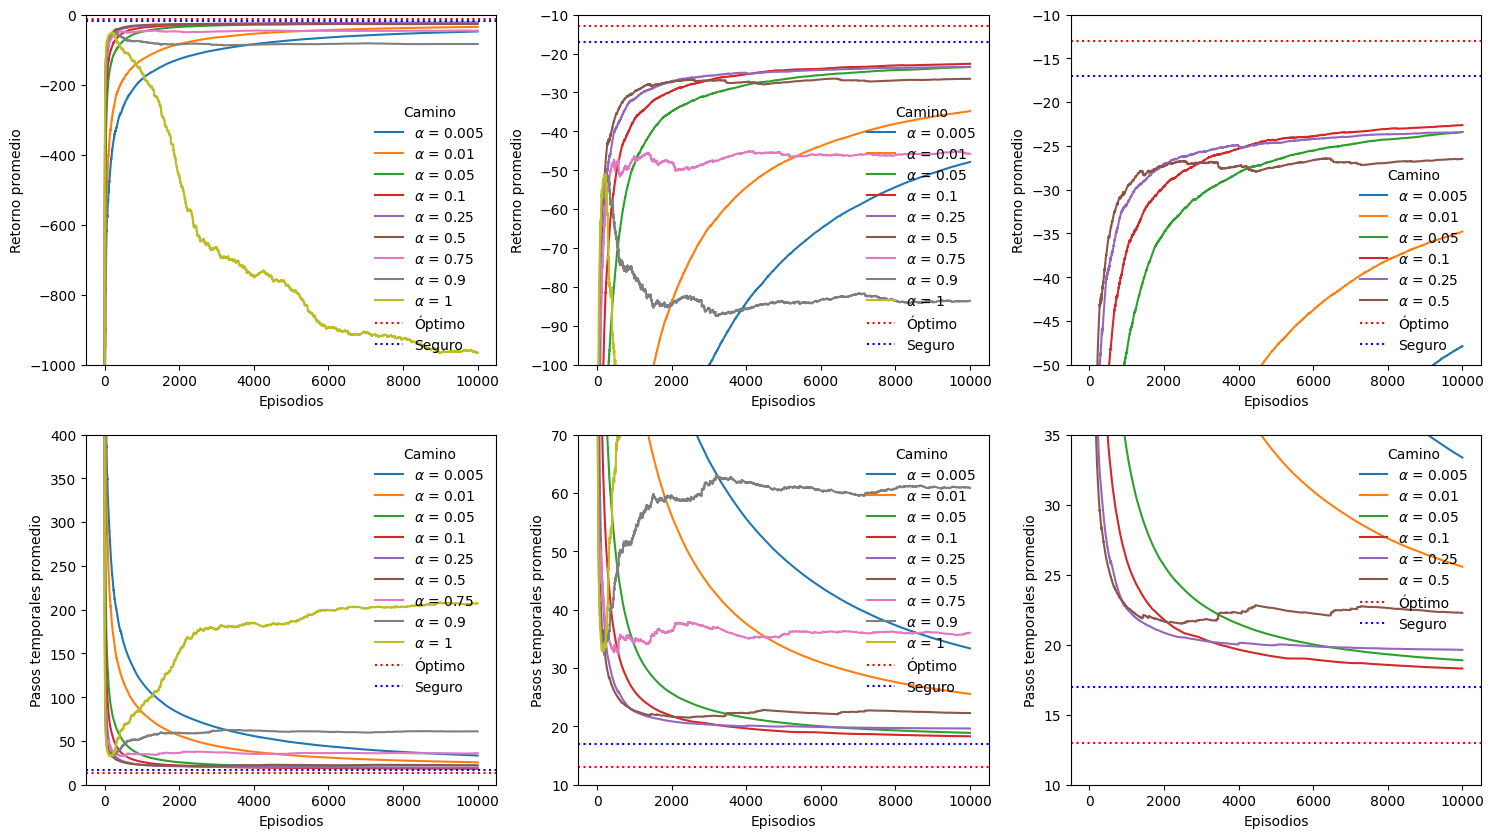

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for p_a in [0.005, 0.01, 0.05, 0.1, 0.25, 0.5]:

    File = pd.read_csv(f'Outputs/Lab1/Alpha/SARSA-epGreedy_its-2000_eps-10000_a-{p_a}_g-1_e-0.1.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    
    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')
    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')
    axs[0, 2].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')

    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')
    axs[1, 2].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')

for p_a in [0.75, 0.9, 1]:

    File = pd.read_csv(f'Outputs/Lab1/Alpha/SARSA-epGreedy_its-2000_eps-10000_a-{p_a}_g-1_e-0.1.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    
    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')
    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')

    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')

axs[0, 0].set_ylim(-1000, 0)
axs[0, 1].set_ylim(-100, -10)
axs[0, 2].set_ylim(-50, -10)

axs[1, 0].set_ylim(0, 400)
axs[1, 1].set_ylim(10, 70)
axs[1, 2].set_ylim(10, 35)

for k in range(3):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')

plt.savefig('Outputs/Lab1/Alpha/SARSA-epGreedy_its-2000_eps-10000_g-1_e-0.1.png')

Figura para comparar barrido de $\gamma$.

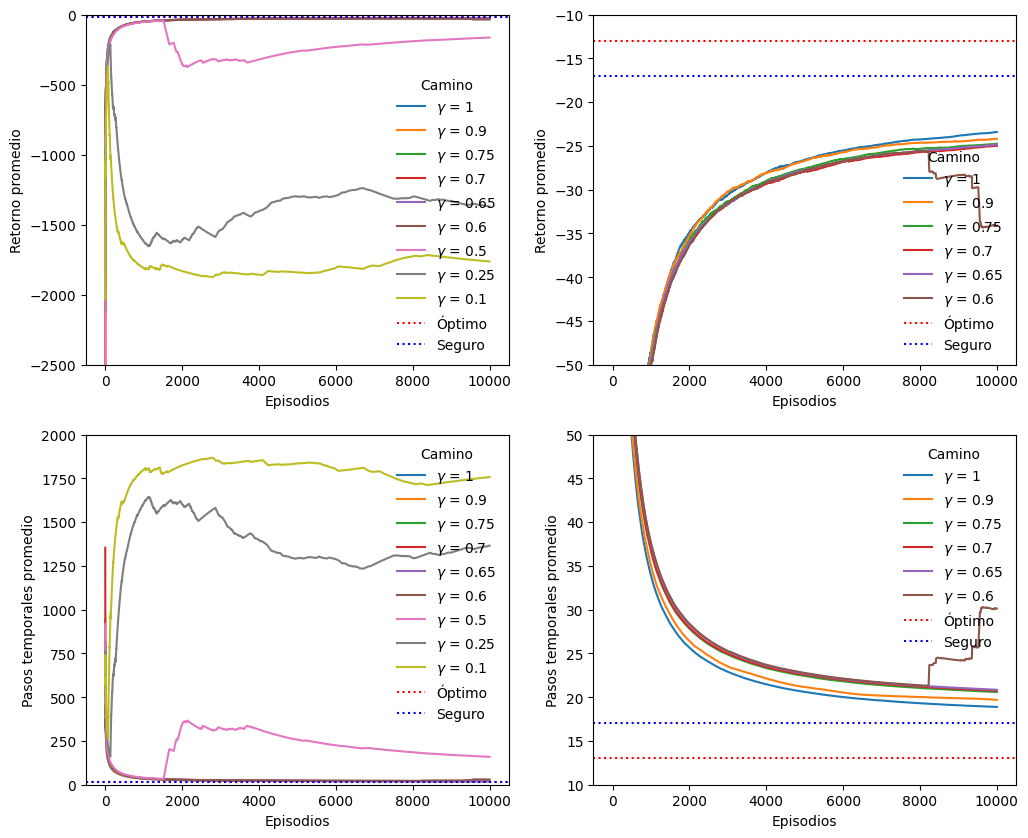

In [9]:
fig, axs = plt.subplots(2, 2,figsize=(12, 10))

for p_g in [1, 0.9, 0.75, 0.7, 0.65, 0.6, 0.5, 0.25, 0.1]:

    File = pd.read_csv(f'Outputs/Lab1/Gamma/SARSA-epGreedy_its-2000_eps-10000_a-0.05_g-{p_g}_e-0.1.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'$\gamma$ = {p_g}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'$\gamma$ = {p_g}')

for p_g in [1, 0.9, 0.75, 0.7, 0.65, 0.6]:

    File = pd.read_csv(f'Outputs/Lab1/Gamma/SARSA-epGreedy_its-2000_eps-10000_a-0.05_g-{p_g}_e-0.1.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'$\gamma$ = {p_g}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'$\gamma$ = {p_g}')

axs[0, 0].set_ylim(-2500, 0)
axs[0, 1].set_ylim(-50, -10)

axs[1, 0].set_ylim(0, 2000)
axs[1, 1].set_ylim(10, 50)

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')

plt.savefig('Outputs/Lab1/Gamma/SARSA-epGreedy_its-2000_eps-10000_a-0.05_e-0.1.png')

Figura para comparar barrido de $\epsilon$.

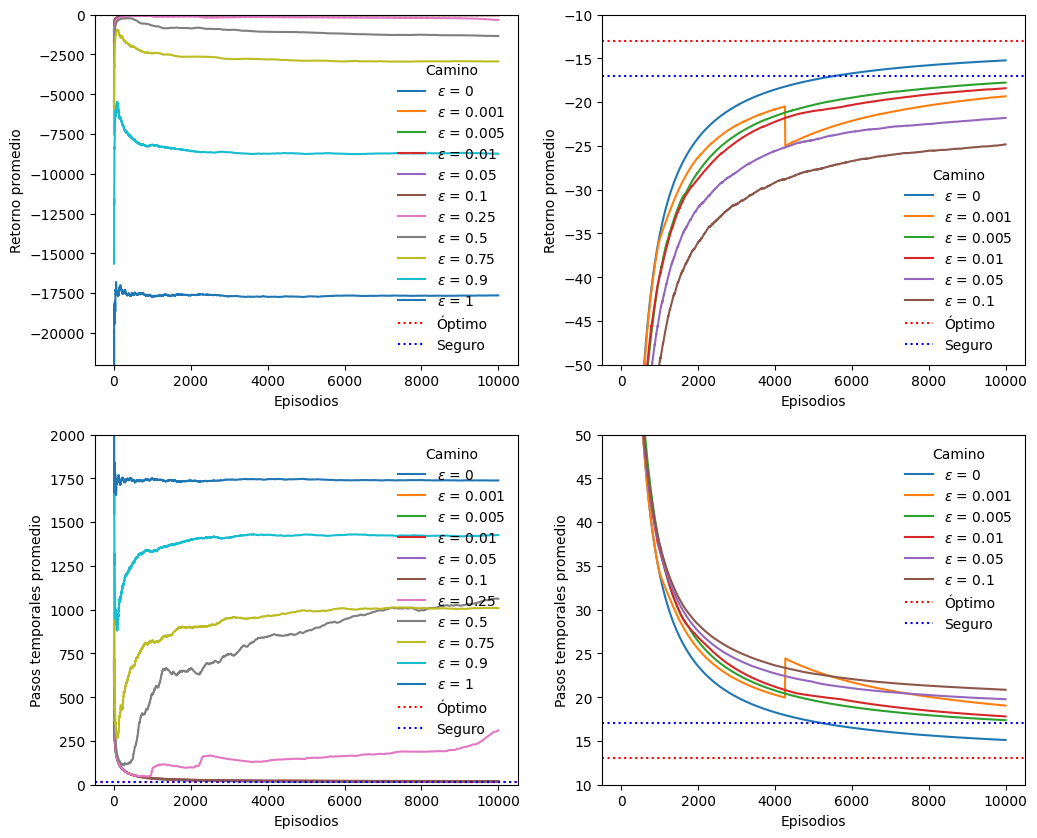

In [10]:
fig, axs = plt.subplots(2, 2,figsize=(12, 10))

for p_e in [0, 0.001, 0.005, 0.01, 0.05, 0.1]:

    File = pd.read_csv(f'Outputs/Lab1/Epsilon/SARSA-epGreedy_its-2000_eps-10000_a-0.05_g-0.65_e-{p_e}.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'$\epsilon$ = {p_e}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'$\epsilon$ = {p_e}')

    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'$\epsilon$ = {p_e}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'$\epsilon$ = {p_e}')

for p_e in [0.25, 0.5, 0.75, 0.9, 1]:

    File = pd.read_csv(f'Outputs/Lab1/Epsilon/SARSA-epGreedy_its-2000_eps-10000_a-0.05_g-0.65_e-{p_e}.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'$\epsilon$ = {p_e}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'$\epsilon$ = {p_e}')

axs[0, 0].set_ylim(-22000, 0)
axs[1, 0].set_ylim(0, 2000)

axs[0, 1].set_ylim(-50, -10)
axs[1, 1].set_ylim(10, 50)

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')

plt.savefig('Outputs/Lab1/Epsilon/SARSA-epGreedy_its-2000_eps-10000_a-0.05_g-0.65.png')

Figura para comparar lo que ocurre al cambiar la cantidad de episodios, utilizando hiperparámetros óptimos y dejando fija o libre la semilla.

/tmp/ipykernel_12494/3292417314.py:6: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-{p_eps}_a-0.05_g-0.65_e-0.005_randomSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
/tmp/ipykernel_12494/3292417314.py:11: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-{p_eps}_a-0.05_g-0.65_e-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
/tmp/ipykernel_12494/3292417314.py:6: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-{p_eps}_a-0.05_g-0.65_e-0.005_randomSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
/tmp/ipykernel_12494/3292417

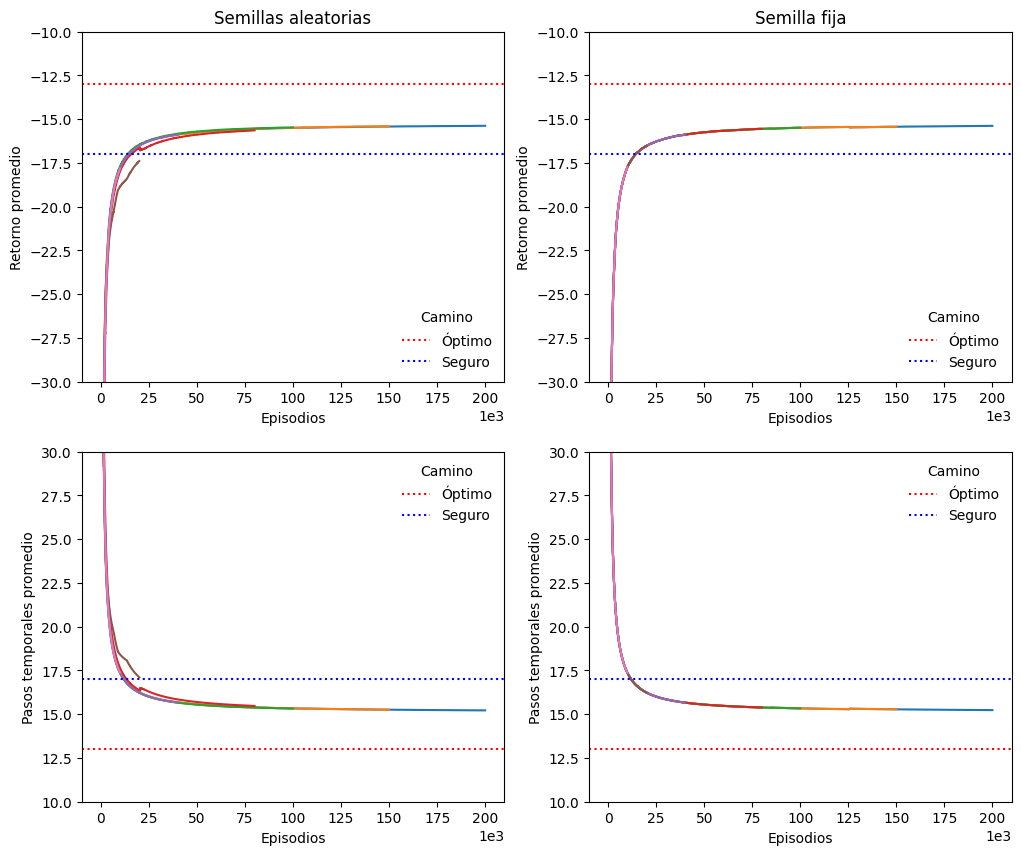

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for p_eps in [200000, 150000,  100000, 80000, 40000, 20000, 10000]:

    # Semillas aleatorias (se usa el número de episodios p_eps correspondiente para reproducibilidad en la "aleatoriedad")
    File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-{p_eps}_a-0.05_g-0.65_e-0.005_randomSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 0].plot(mean_evol(File[:,0]))
    axs[1, 0].plot(mean_evol(File[:,1]))

    # # Semillas fija (1994)
    File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-{p_eps}_a-0.05_g-0.65_e-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 1].plot(mean_evol(File[:,0]))
    axs[1, 1].plot(mean_evol(File[:,1]))

axs[0, 0].set_title('Semillas aleatorias')
axs[0, 1].set_title('Semilla fija')

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')
    axs[0, k].set_ylim(-30, -10)

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')
    axs[1, k].set_ylim(10, 30)

    axs[0, k].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
    axs[1, k].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

plt.savefig('Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_a-0.05_g-0.65_e-0.005.png')

Generar mapa

In [12]:
def draw_value_matrix(q) -> None:
    '''
    Grafica el mapa del juego mostrando la ruta más conveniente según el
    algoritmo de aprendizaje utilizado.
    '''

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.title('Ruta más conveniente')
    plt.show()

Grilla resultante

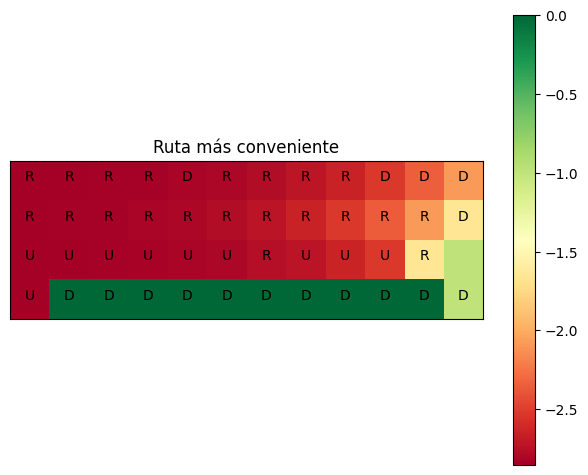

In [13]:
File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-0.005_fixedSeed.csv', header=None, sep='\t').iloc[4:200, 2].to_numpy().astype(float)
q = {}
k = 0
for s in range(49):
    for a in range(4):
        q[(s, a)] = File[s+a+k]
    k += 3

draw_value_matrix(q)

---
# Ejercicio: Q-learning + $\epsilon$-greedy

En esta actividad se implementa y ejecuta el algoritmo Q-learning con una política $\epsilon$-greedy. Se estudia además el efecto de los hiperparámetros sobre la convergencia.

## Aprendizaje por diferencias temporales off-policy: Q-learning

Se define a Q-learning como el método de aprendizaje, tomando una transición y cambiando el diccionario de los valores de Q.

In [14]:
def Q_learning(
    state: int,
    action: int,
    reward: int,
    next_state: int,
    actions: range,
    hyperparameters: dict,
    q: dict
) -> Tuple[int, int]:

    """
    Realiza una actualización según el algoritmo Q-learning, para una 
    transición de estado dada.
    Args:
        state: estado actual del agente
        action: acción actual ejecutada por el agente
        reward: recompensa recibida al ejecutar la acción
        next_state: próximo estado del agente
        actions: lista de acciones posibles
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        q: diccionario de valores de estado-acción
    """

    # Lista de valores q asociados a un estado-acción
    q_values = [q.get((state, a)) for a in actions]

    # Toma el valor máximo
    max_q = max(q_values)

    # Puede haber más de un valor máximo
    count = q_values.count(max_q)

    if count > 1:
        # Hay más de un valor máximo. Sorteamos alguno de ellos
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    
    else:
        # Hay un único valor máximo, eligiendo el correspondiente estado-acción
        i = q_values.index(max_q)

    # Actualizo el valor del estado-acción
    Target = reward + hyperparameters['gamma']  * q[(next_state, actions[i])]
    TD_error = Target - q[(state, action)]
    q[(state, action)] += hyperparameters['alpha'] * TD_error

    # Actualizo el estado
    state = next_state

    return state

## Iteraciones

Se define la manera en la que itera el algoritmo Q-learning.

In [15]:
def run_Q_learning(
    policy: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    random_state: np.random.RandomState,
    max_iter: int
) -> Tuple[np.ndarray, np.ndarray, int, int, int, dict]:

    """
    Corre el algoritmo de RL, basado en Q-learning.
    Args:
        policy: huerística de selección de acciones
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: entorno de Gymnasium
        actions: lista de acciones posibles
        random_state: generador de números aleatorios
        max_iter: cantidad máxima de pasos temporales
    """

    # Inicialización del diccionario de valores de estado-acción
    q = {}
    for s in range(49):
        for a in range(4):
            q[(s, a)] = 0.0

    # Registra la cantidad de pasos de cada episodio
    timesteps_of_episode = []

    # Registra el retorno de cada episodio
    return_of_episode = []

    # Casuísticas de finalización
    goal, drop, early = 0, 0, 0

    # Loop sobre los episodios
    for _ in range(episodes_to_run):
        # Instancea un nuevo agente en cada episodio
        # Fin del episodio: llegar a la salida o superar max_iter

        # Reinicia el entorno, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        # Retorno del episodio
        episode_return = 0

        # Contador de pasos temporales
        t = 0

        # Flag de finalización de iteración actual
        done = False

        while not done:
            # Elige la acción a ejecutar
            action = policy(
                state, actions, q, hyperparameters, random_state)
        
            # El agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Acumulamos recompensa
            episode_return += reward

            # Mecanismo de aprendizaje por TD con Q-learning
            state= Q_learning(
                state, action, reward, next_state, actions, hyperparameters, q)

            # Análisis de convergencia
            if terminated:
                # El agente alcanzó el objetivo
                goal += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif truncated:
                # El agente ejecutó una acción inválida
                drop += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif t >= max_iter:
                # Early stopping
                early += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            t += 1

    return timesteps_of_episode, return_of_episode, goal, drop, early, q

## Implementación

Se definen el entorno, los parámetros e hiperparámetros deseados para la corrida. Luego corre y, finalmente, guarda los resultados. Se pueden ejecutar barridas de parámetros gracias a los for anidados. A continuación se tienen celdas que grafican comparativamente.

### Run

In [16]:
env = gym.make("CliffWalking-v0")#, render_mode="human")
actions = range(env.action_space.n)
policy = epGreedy

max_iter = 2000
Sw_eps = [100000] # [10000, 20000, 40000, 80000, 100000]
Sw_a = [0.05] # [0.05, 0.1, 0.2, 0.25]
Sw_g = [0.65] # [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
Sw_e = [0.005, 0.01, 0.05] # [0.005]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                hyperparameters = {
                    "alpha": p_a,
                    "gamma": p_g,
                    "epsilon": p_e,
                }

                random_state = np.random.RandomState(1994)
                # random_state = np.random.RandomState(p_eps)

                start = time.time()
                ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_Q_learning(
                    policy,
                    hyperparameters,
                    episodes_to_run,
                    env,
                    actions,
                    random_state,
                    max_iter
                )
                WallTime = time.time() - start

                env.close()

                # Guardamos los resultados
                runType = f'Qlearning-{policy.__name__}'
                runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_e-{hyperparameters["epsilon"]}'

                with open(f'Outputs/Lab1/{runType}_{runPar}_{runHPar}.csv', 'w') as f:
                    f.write('Goal\tDrop\tEarly\tTotal\n')
                    f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                    f.write(f'Wall Time[s]\t{WallTime}\n')
                    
                    f.write('State\tAction\tQ-value\n')
                    for s in range(49):
                        for a in range(4):
                            f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                    f.write('Return\tTimeSteps\n')
                    for i in range(episodes_to_run):
                        f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

### Plot

Figura para comparar lo que ocurre al cambiar la cantidad de episodios y, además, ver que es determinista.

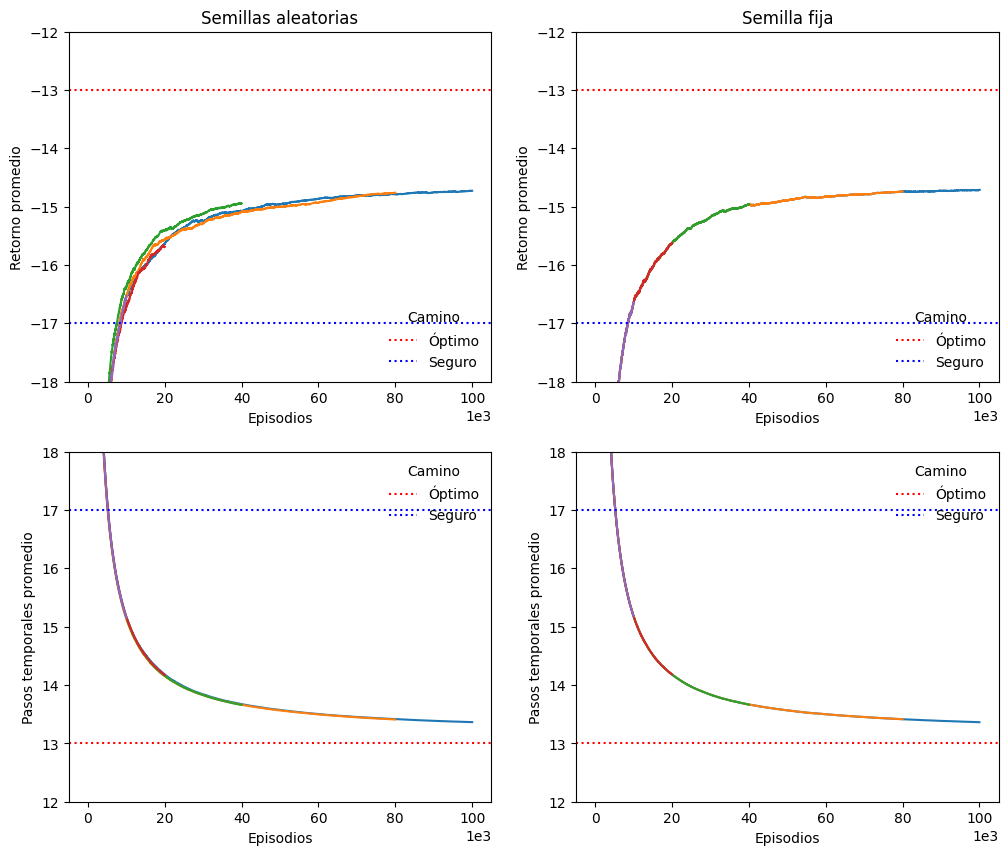

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for p_eps in [100000, 80000, 40000, 20000, 10000]:

    # Semillas aleatorias (se usa el número de episodios p_eps correspondiente para reproducibilidad en la "aleatoriedad")
    File = pd.read_csv(f'Outputs/Lab1/Determinista/Qlearning-epGreedy_its-2000_eps-{p_eps}_a-0.05_g-0.65_e-0.005_randomSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 0].plot(mean_evol(File[:,0]))
    axs[1, 0].plot(mean_evol(File[:,1]))

    # Semillas fija (1994)
    File = pd.read_csv(f'Outputs/Lab1/Determinista/Qlearning-epGreedy_its-2000_eps-{p_eps}_a-0.05_g-0.65_e-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 1].plot(mean_evol(File[:,0]))
    axs[1, 1].plot(mean_evol(File[:,1]))

axs[0, 0].set_title('Semillas aleatorias')
axs[0, 1].set_title('Semilla fija')

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')
    axs[0, k].set_ylim(-18, -12)

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')
    axs[1, k].set_ylim(12, 18)

    axs[0, k].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
    axs[1, k].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

plt.savefig('Outputs/Lab1/Determinista/Qlearning-epGreedy_its-2000_a-0.05_g-0.65_e-0.005.png')

Figura para comparar barrido de $\alpha$.

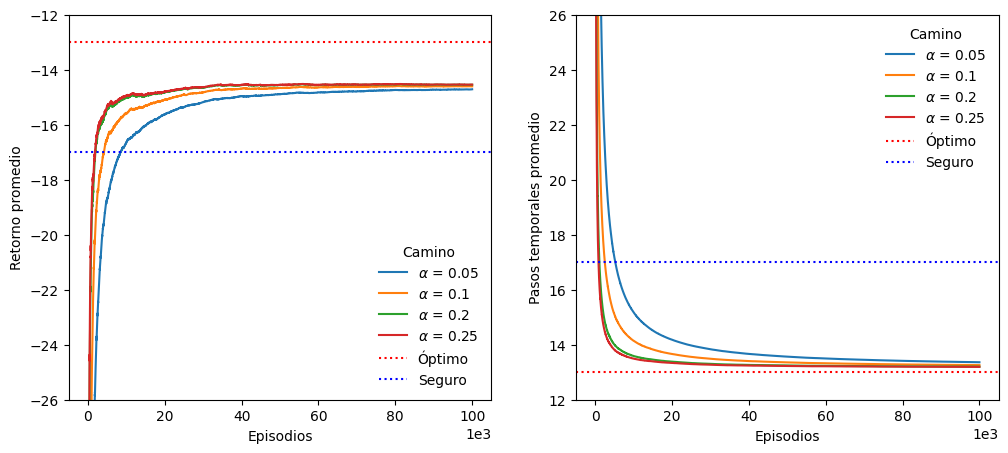

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for p_a in [0.05, 0.1, 0.2, 0.25]:

    File = pd.read_csv(f'Outputs/Lab1/Alpha/Qlearning-epGreedy_its-2000_eps-100000_a-{p_a}_g-0.65_e-0.005.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    
    axs[0].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')
    axs[1].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')

axs[0].set_ylim(-26, -12)
axs[1].set_ylim(12, 26)

axs[0].axhline(-13, color='red', linestyle=':', label='Óptimo')
axs[0].axhline(-17, color='blue', linestyle=':', label='Seguro')

axs[0].set_xlabel('Episodios')
axs[1].set_xlabel('Episodios')

axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

axs[0].set_ylabel('Retorno promedio')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

plt.savefig('Outputs/Lab1/Alpha/Qlearning-epGreedy_its-2000_eps-100000_g-0.65_e-0.005.png')

Figura para comparar barrido de $\gamma$.

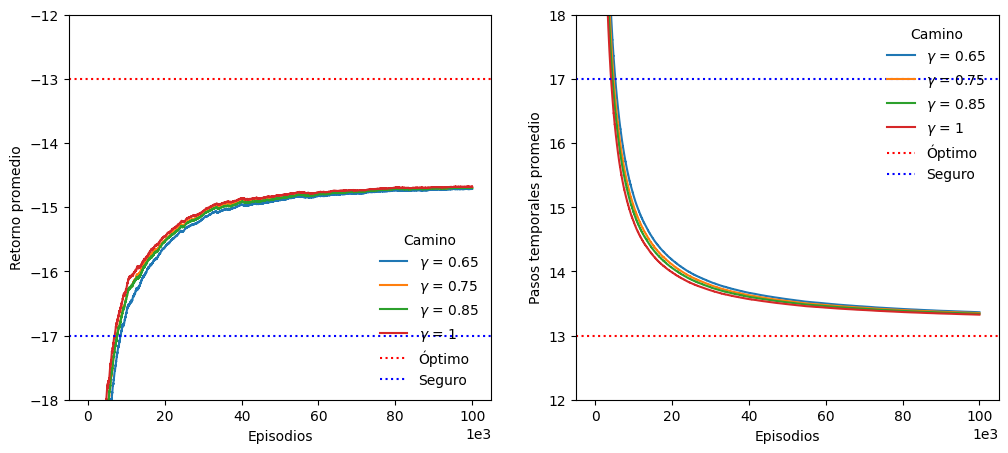

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for p_g in [0.65, 0.75, 0.85, 1]:

    File = pd.read_csv(f'Outputs/Lab1/Gamma/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_g-{p_g}_e-0.005.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    
    axs[0].plot(mean_evol(File[:,0]), label=rf'$\gamma$ = {p_g}')
    axs[1].plot(mean_evol(File[:,1]), label=rf'$\gamma$ = {p_g}')

axs[0].set_ylim(-18, -12)
axs[1].set_ylim(12, 18)

axs[0].axhline(-13, color='red', linestyle=':', label='Óptimo')
axs[0].axhline(-17, color='blue', linestyle=':', label='Seguro')

axs[0].set_xlabel('Episodios')
axs[1].set_xlabel('Episodios')

axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

axs[0].set_ylabel('Retorno promedio')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

plt.savefig('Outputs/Lab1/Gamma/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_e-0.005.png')

Figura para comparar barrido de $\epsilon$.

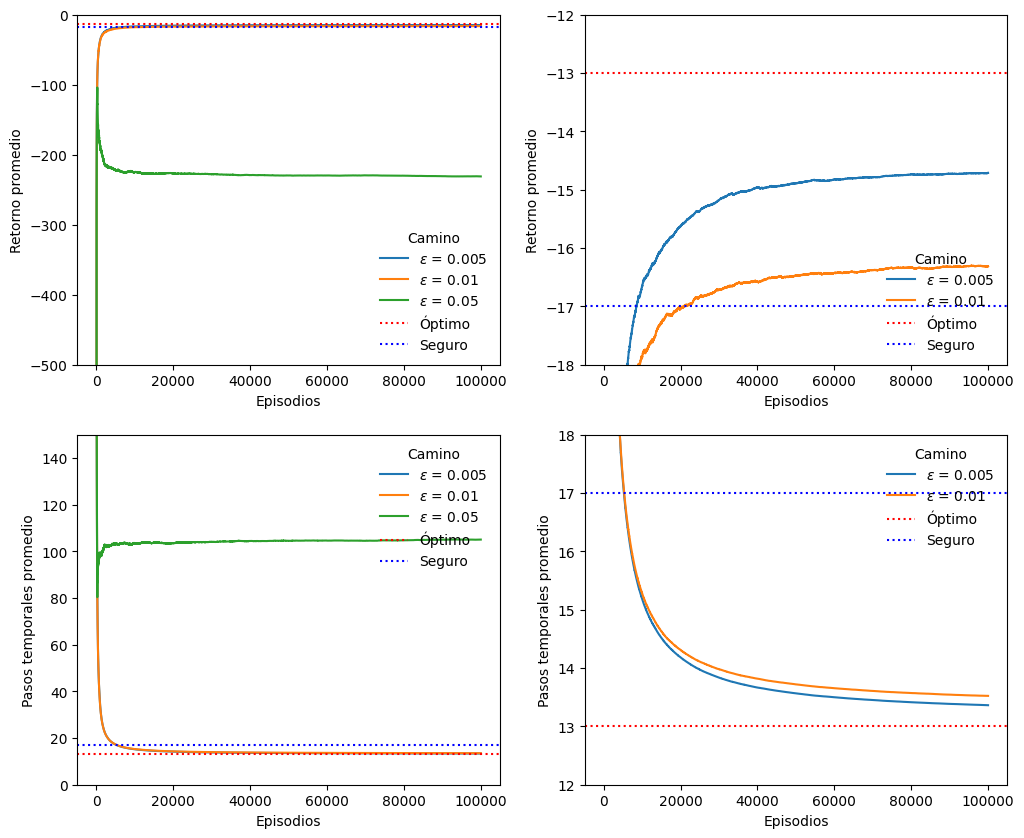

In [20]:
fig, axs = plt.subplots(2, 2,figsize=(12, 10))

for p_e in [0.005, 0.01]:

    File = pd.read_csv(f'Outputs/Lab1/Epsilon/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-{p_e}.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'$\epsilon$ = {p_e}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'$\epsilon$ = {p_e}')

    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'$\epsilon$ = {p_e}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'$\epsilon$ = {p_e}')

for p_e in [0.05]:

    File = pd.read_csv(f'Outputs/Lab1/Epsilon/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-{p_e}.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'$\epsilon$ = {p_e}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'$\epsilon$ = {p_e}')

axs[0, 0].set_ylim(-500, 0)
axs[1, 0].set_ylim(0, 150)

axs[0, 1].set_ylim(-18, -12)
axs[1, 1].set_ylim(12, 18)

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')

plt.savefig('Outputs/Lab1/Epsilon/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_g-0.65.png')

Grilla resultante

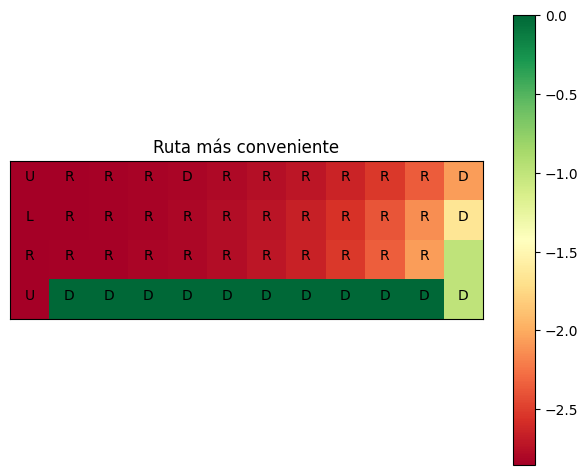

In [21]:
File = pd.read_csv(f'Outputs/Lab1/Epsilon/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-0.005.csv', header=None, sep='\t').iloc[4:200, 2].to_numpy().astype(float)
q = {}
k = 0
for s in range(49):
    for a in range(4):
        q[(s, a)] = File[s+a+k]
    k += 3

draw_value_matrix(q)

Comparación entre SARSA y Q-learning.

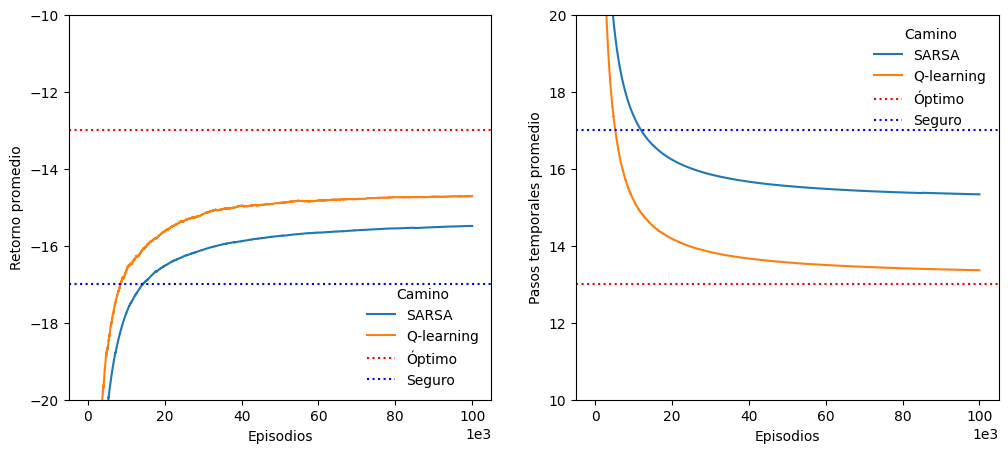

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label='SARSA')
axs[1].plot(mean_evol(File[:,1]), label='SARSA')

File = pd.read_csv(f'Outputs/Lab1/Epsilon/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-0.005.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label='Q-learning')
axs[1].plot(mean_evol(File[:,1]), label='Q-learning')

axs[0].set_ylim(-20, -10)
axs[1].set_ylim(10, 20)

axs[0].axhline(-13, color='red', linestyle=':', label='Óptimo')
axs[0].axhline(-17, color='blue', linestyle=':', label='Seguro')

axs[0].set_xlabel('Episodios')
axs[1].set_xlabel('Episodios')

axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

axs[0].set_ylabel('Retorno promedio')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

plt.savefig('Outputs/Lab1/SARSAvsQlearning_epGreedy.png')

---
# Ejercicio: Política SoftMax

En esta actividad se implementan y ejecutan tanto el algoritmo SARSA como Q-learning, aplicando esta vez una política SoftMax. Se estudia además el efecto de los hiperparámetros sobre la convergencia.

## Heurística de selección de acciones: política SoftMax

Se define a SoftMax como el método para decidir qué acciones tomar.

In [23]:
def SoftMax(
    state: int,
    actions: range,
    q: dict,
    hyperparameters: dict,
    random_state: np.random.RandomState
) -> int:

    """
    Elije una acción de acuerdo a una política de exploración-explotación SoftMax.
    Args:
        state: estado actual del agente
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        random_state: generador de números aleatorios
    Nota:
        Para facilitar la reutilización de código, se toma a epsilon como tau.
    """

    # Lista de valores q asociados a un estado-acción
    q_values = np.array([q.get((state, a)) for a in actions])

    # Aplico las exponenciales
    exp_qt = np.exp(q_values / hyperparameters['epsilon'])

    # Constante de normalización
    norm = np.sum(exp_qt)

    # Distribución de probabilidad
    distrib = exp_qt / norm

    # Muestreamos la distribución, obteniendo la acción
    action = random_state.choice(actions, p=distrib)

    return action

## Implementación

Se definen el entorno, los parámetros e hiperparámetros deseados para la corrida. Luego corre y, finalmente, guarda los resultados. Se pueden ejecutar barridas de parámetros gracias a los for anidados. A continuación se tienen celdas que grafican comparativamente.

***Nota:*** para facilitar la reutilización de código, se toma a epsilon como tau.

### Run

SARSA+SoftMax

In [24]:
env = gym.make("CliffWalking-v0")#, render_mode="human")
actions = range(env.action_space.n)
policy = SoftMax

max_iter = 2000
Sw_eps = [100000]
Sw_a = [0.05] # [0.05, 0.1, 0.2, 0.25]
Sw_g = [0.60] # [0.65]
Sw_e = [0.005] # [0.005, 0.01, 0.05]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                hyperparameters = {
                    "alpha": p_a,
                    "gamma": p_g,
                    "epsilon": p_e,
                }

                random_state = np.random.RandomState(1994)

                start = time.time()
                ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_SARSA(
                    policy,
                    hyperparameters,
                    episodes_to_run,
                    env,
                    actions,
                    random_state,
                    max_iter
                )
                WallTime = time.time() - start

                env.close()

                # Guardamos los resultados
                runType = f'SARSA-{policy.__name__}'
                runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_t-{hyperparameters["epsilon"]}'

                with open(f'Outputs/Lab1/{runType}_{runPar}_{runHPar}_fixedSeed.csv', 'w') as f:
                    f.write('Goal\tDrop\tEarly\tTotal\n')
                    f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                    f.write(f'Wall Time[s]\t{WallTime}\n')
                    
                    f.write('State\tAction\tQ-value\n')
                    for s in range(49):
                        for a in range(4):
                            f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                    f.write('Return\tTimeSteps\n')
                    for i in range(episodes_to_run):
                        f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

Q-learning+SoftMax

In [25]:
env = gym.make("CliffWalking-v0")#, render_mode="human")
actions = range(env.action_space.n)
policy = SoftMax

max_iter = 2000
Sw_eps = [100000]
Sw_a = [0.05] # [0.05, 0.1, 0.2, 0.25]
Sw_g = [0.7] # [0.65]
Sw_e = [0.005] # [0.005, 0.01, 0.05]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                hyperparameters = {
                    "alpha": p_a,
                    "gamma": p_g,
                    "epsilon": p_e,
                }

                random_state = np.random.RandomState(1994)

                start = time.time()
                ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_Q_learning(
                    policy,
                    hyperparameters,
                    episodes_to_run,
                    env,
                    actions,
                    random_state,
                    max_iter
                )
                WallTime = time.time() - start

                env.close()

                # Guardamos los resultados
                runType = f'Qlearning-{policy.__name__}'
                runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_t-{hyperparameters["epsilon"]}'

                with open(f'Outputs/Lab1/{runType}_{runPar}_{runHPar}_fixedSeed.csv', 'w') as f:
                    f.write('Goal\tDrop\tEarly\tTotal\n')
                    f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                    f.write(f'Wall Time[s]\t{WallTime}\n')
                    
                    f.write('State\tAction\tQ-value\n')
                    for s in range(49):
                        for a in range(4):
                            f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                    f.write('Return\tTimeSteps\n')
                    for i in range(episodes_to_run):
                        f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

### Plot

Figura para comparar barrido de $\tau$.

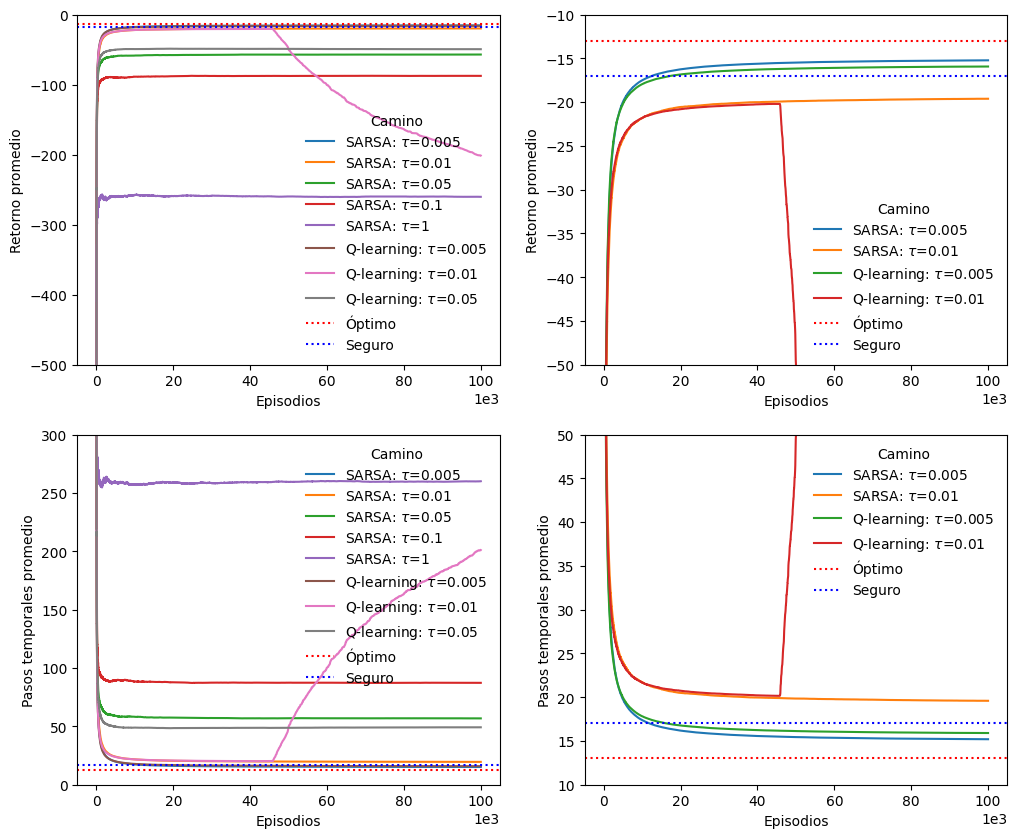

In [26]:
fig, axs = plt.subplots(2, 2,figsize=(12, 10))

# SARSA
for tau in [0.005, 0.01]:
    File = pd.read_csv(f'Outputs/Lab1/Tau/SARSA-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-{tau}_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'SARSA: $\tau$={tau}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'SARSA: $\tau$={tau}')

    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'SARSA: $\tau$={tau}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'SARSA: $\tau$={tau}')

for tau in [0.05, 0.1, 1]:
    File = pd.read_csv(f'Outputs/Lab1/Tau/SARSA-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-{tau}_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'SARSA: $\tau$={tau}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'SARSA: $\tau$={tau}')

# Q-learning
for tau in [0.005, 0.01]:
    File = pd.read_csv(f'Outputs/Lab1/Tau/Qlearning-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-{tau}_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'Q-learning: $\tau$={tau}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'Q-learning: $\tau$={tau}')

    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'Q-learning: $\tau$={tau}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'Q-learning: $\tau$={tau}')

for tau in [0.05]:
    File = pd.read_csv(f'Outputs/Lab1/Tau/Qlearning-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-{tau}_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'Q-learning: $\tau$={tau}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'Q-learning: $\tau$={tau}')

axs[0, 0].set_ylim(-500, 0)
axs[1, 0].set_ylim(0, 300)

axs[0, 1].set_ylim(-50, -10)
axs[1, 1].set_ylim(10, 50)

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')

    axs[0, k].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
    axs[1, k].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

plt.savefig('Outputs/Lab1/Tau/SoftMax_its-2000_eps-100000_a-0.05_g-0.65_fixedSeed.png')

Figura para comparar barrido de $\alpha$.

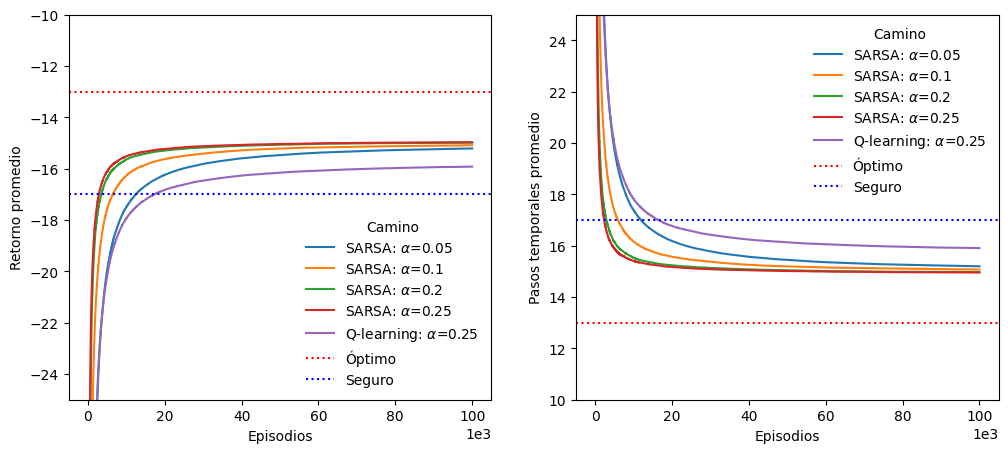

In [27]:
fig, axs = plt.subplots(1, 2,figsize=(12, 5))

# SARSA
for p_a in [0.05, 0.1, 0.2, 0.25]:
    File = pd.read_csv(f'Outputs/Lab1/Alpha/SARSA-SoftMax_its-2000_eps-100000_a-{p_a}_g-0.65_t-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0].plot(mean_evol(File[:,0]), label=rf'SARSA: $\alpha$={p_a}')
    axs[1].plot(mean_evol(File[:,1]), label=rf'SARSA: $\alpha$={p_a}')

# Q-learning
File = pd.read_csv(f'Outputs/Lab1/Alpha/Qlearning-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label=rf'Q-learning: $\alpha$={p_a}')
axs[1].plot(mean_evol(File[:,1]), label=rf'Q-learning: $\alpha$={p_a}')

axs[0].set_ylim(-25, -10)
axs[1].set_ylim(10, 25)

axs[0].axhline(-13, color='red', linestyle=':', label='Óptimo')
axs[0].axhline(-17, color='blue', linestyle=':', label='Seguro')
axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

axs[0].set_xlabel('Episodios')
axs[0].set_ylabel('Retorno promedio')

axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

axs[1].set_xlabel('Episodios')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

plt.savefig('Outputs/Lab1/Alpha/SoftMax_its-2000_eps-100000_g-0.65_t-0.005_fixedSeed.png')

Figura para comparar barrido de $\gamma$.

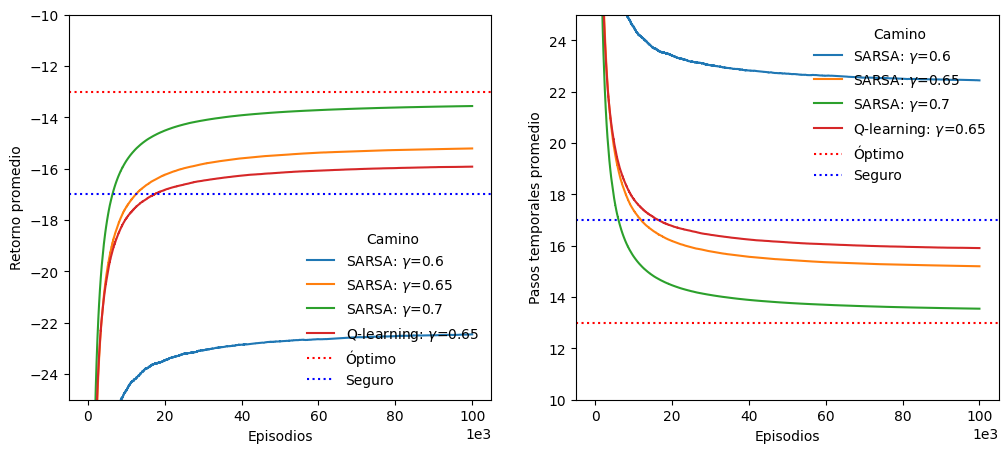

In [28]:
fig, axs = plt.subplots(1, 2,figsize=(12, 5))

# SARSA
for p_g in [0.6, 0.65, 0.7]:
    File = pd.read_csv(f'Outputs/Lab1/Gamma/SARSA-SoftMax_its-2000_eps-100000_a-0.05_g-{p_g}_t-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
    axs[0].plot(mean_evol(File[:,0]), label=rf'SARSA: $\gamma$={p_g}')
    axs[1].plot(mean_evol(File[:,1]), label=rf'SARSA: $\gamma$={p_g}')

# Q-learning
File = pd.read_csv(f'Outputs/Lab1/Gamma/Qlearning-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label=rf'Q-learning: $\gamma$=0.65')
axs[1].plot(mean_evol(File[:,1]), label=rf'Q-learning: $\gamma$=0.65')

axs[0].set_ylim(-25, -10)
axs[1].set_ylim(10, 25)

axs[0].axhline(-13, color='red', linestyle=':', label='Óptimo')
axs[0].axhline(-17, color='blue', linestyle=':', label='Seguro')
axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

axs[0].set_xlabel('Episodios')
axs[0].set_ylabel('Retorno promedio')

axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

axs[1].set_xlabel('Episodios')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

plt.savefig('Outputs/Lab1/Gamma/SoftMax_its-2000_eps-100000_a-0.05_t-0.005_fixedSeed.png')

Comparación global

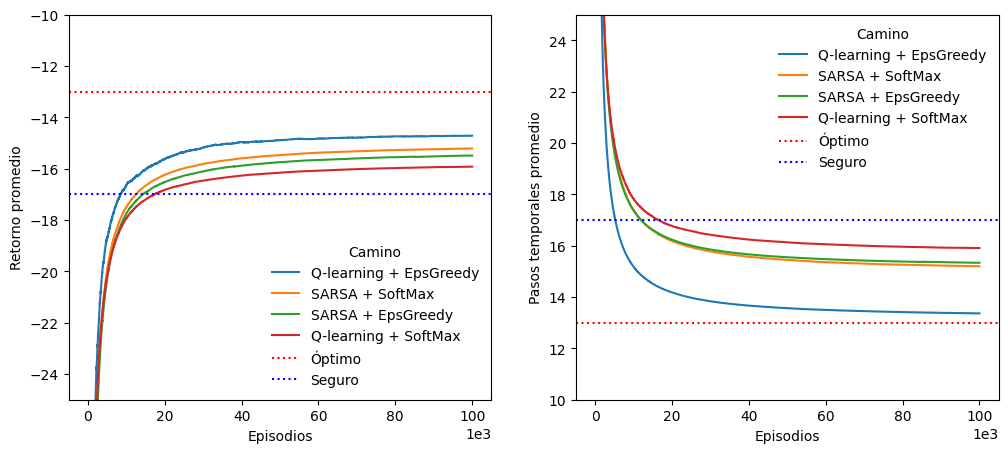

In [29]:
fig, axs = plt.subplots(1, 2,figsize=(12, 5))

# Q-learning - Greedy
File = pd.read_csv(f'Outputs/Lab1/Epsilon/Qlearning-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-0.005.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label='Q-learning + EpsGreedy')
axs[1].plot(mean_evol(File[:,1]), label='Q-learning + EpsGreedy')

# SARSA - SoftMax
File = pd.read_csv(f'Outputs/Lab1/Gamma/SARSA-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label=rf'SARSA + SoftMax')
axs[1].plot(mean_evol(File[:,1]), label=rf'SARSA + SoftMax')

# SARSA - Greedy
File = pd.read_csv(f'Outputs/Lab1/Optimos/SARSA-epGreedy_its-2000_eps-100000_a-0.05_g-0.65_e-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label='SARSA + EpsGreedy')
axs[1].plot(mean_evol(File[:,1]), label='SARSA + EpsGreedy')

# Q-learning - SoftMax
File = pd.read_csv(f'Outputs/Lab1/Gamma/Qlearning-SoftMax_its-2000_eps-100000_a-0.05_g-0.65_t-0.005_fixedSeed.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)
axs[0].plot(mean_evol(File[:,0]), label=rf'Q-learning + SoftMax')
axs[1].plot(mean_evol(File[:,1]), label=rf'Q-learning + SoftMax')

axs[0].set_ylim(-25, -10)
axs[1].set_ylim(10, 25)

axs[0].axhline(-13, color='red', linestyle=':', label='Óptimo')
axs[0].axhline(-17, color='blue', linestyle=':', label='Seguro')
axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

axs[0].set_xlabel('Episodios')
axs[0].set_ylabel('Retorno promedio')

axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

axs[1].set_xlabel('Episodios')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

plt.savefig('Outputs/Lab1/Best4.png')

---
# Ejercicio: Dyna-Q

En esta actividad se implementa y ejecuta Dyna-Q.

## Iteraciones

Se define la manera en la que itera el algoritmo Dyna-Q.

In [ ]:
def run_DynaQ(
    policy: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    random_state: np.random.RandomState,
    max_iter: int
) -> Tuple[np.ndarray, np.ndarray, int, int, int, dict]:

    """
    Corre el algoritmo de RL, basado en Dyna-Q.
    Args:
        policy: huerística de selección de acciones
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: entorno de Gymnasium
        actions: lista de acciones posibles
        random_state: generador de números aleatorios
        max_iter: cantidad máxima de pasos temporales
    """

    # Pasos de planificación
    plan = hyperparameters['steps']

    # Inicialización del diccionario de valores de estado-acción
    q = {}
    for s in range(49):
        for a in range(4):
            q[(s, a)] = 0.0

    # Inicialización del diccionario del modelo
    Mod = {}

    # Registra la cantidad de pasos de cada episodio
    timesteps_of_episode = []

    # Registra el retorno de cada episodio
    return_of_episode = []

    # Casuísticas de finalización
    goal, drop, early = 0, 0, 0

    # Loop sobre los episodios
    for _ in range(episodes_to_run):
        # Instancea un nuevo agente en cada episodio
        # Fin del episodio: llegar a la salida o superar max_iter

        # Reinicia el entorno, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        # Retorno del episodio
        episode_return = 0

        # Contador de pasos temporales
        t = 0

        # Flag de finalización de iteración actual
        done = False

        while not done:
            # Elige la acción a ejecutar
            action = policy(
                state, actions, q, hyperparameters, random_state)
        
            # El agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Acumulamos recompensa
            episode_return += reward

            # Actualizamos el modelo
            if state not in Mod.keys():
                Mod[state] = {}
            Mod[state][action] = (reward, next_state)

            # Mecanismo de aprendizaje con Q-learning
            state = Q_learning(
                state, action, reward, next_state, actions, hyperparameters, q)

            # Planificación
            for _ in range(plan):
                # Muestreamos un estado-acción ya conocido por el modelo
                plan_S = random_state.choice(Mod.keys())
                plan_A = random_state.choice(Mod[plan_S].keys())

                # Obtenemos recompensa y próximo estado asociados
                plan_R, plan_nextS = Mod[plan_S][plan_A]

                # Actualizamos Q
                __ = Q_learning(
                    plan_S, plan_A, plan_R, plan_nextS, actions, hyperparameters, q)

            # Análisis de convergencia
            if terminated:
                # El agente alcanzó el objetivo
                goal += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif truncated:
                # El agente ejecutó una acción inválida
                drop += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif t >= max_iter:
                # Early stopping
                early += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            t += 1

    return timesteps_of_episode, return_of_episode, goal, drop, early, q

## Implementación

Se definen el entorno, los parámetros e hiperparámetros deseados para la corrida. Luego corre y, finalmente, guarda los resultados.

### Run

In [ ]:
env = gym.make("CliffWalking-v0")#, render_mode="human")
actions = range(env.action_space.n)
policy = epGreedy

max_iter = 2000
Sw_eps = [100000]
Sw_a = [0.05]
Sw_g = [0.65]
Sw_e = [0.005]
Sw_s = [0, 10, 20, 40, 80, 100]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                for p_s in Sw_s:
                    hyperparameters = {
                        "alpha": p_a,
                        "gamma": p_g,
                        "epsilon": p_e,
                        "steps": p_s
                    }

                    random_state = np.random.RandomState(1994)

                    start = time.time()
                    ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_DynaQ(
                        policy,
                        hyperparameters,
                        episodes_to_run,
                        env,
                        actions,
                        random_state,
                        max_iter
                    )
                    WallTime = time.time() - start

                    env.close()

                    # Guardamos los resultados
                    runType = f'DynaQ-{policy.__name__}'
                    runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                    runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_e-{hyperparameters["epsilon"]}_s-{hyperparameters["steps"]}'

                    with open(f'Outputs/Lab1/{runType}_{runPar}_{runHPar}.csv', 'w') as f:
                        f.write('Goal\tDrop\tEarly\tTotal\n')
                        f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                        f.write(f'Wall Time[s]\t{WallTime}\n')
                        
                        f.write('State\tAction\tQ-value\n')
                        for s in range(49):
                            for a in range(4):
                                f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                        f.write('Return\tTimeSteps\n')
                        for i in range(episodes_to_run):
                            f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')